In [1]:
include("../src/modules/TUM69.jl")
include("../src/modules/Preprocess.jl")
include("../src/modules/Network.jl")
include("../src/modules/Utils.jl")

## Third party packages
using Knet: KnetArray, adam, relu, minibatch
using AutoGrad, Knet, CUDA, MAT


## Handwritten modules
using .TUM69: load_image_data   # Data reading
using .Preprocess: process_image # Preprocessing on the data
using .Network: GCN, train_summarize!, accuracy4, nll4, GenericMLP # Construction of custom network
using .Utils: notify

In [2]:
# Some constants that will be used in the network model
MINIBATCH_SIZE = 2
INPUT_SIZE = [384, 384, 3]
OUTPUT_SIZE = 69;

In [3]:
alexnet = matread("alexnet.mat")

Dict{String,Any} with 4 entries:
  "meta"   => Dict{String,Any}("classes"=>Dict{String,Any}("name"=>Any["n014407…
  "params" => Dict{String,Any}("name"=>Any["conv1f" "conv1b" … "fc8f" "fc8b"],"…
  "vars"   => Dict{String,Any}("name"=>Any["input" "x1" … "prediction" "prob"],…
  "layers" => Dict{String,Any}("name"=>Any["conv1" "relu1" … "fc8" "prob"],"out…

In [4]:
alexnet["params"]

Dict{String,Any} with 4 entries:
  "name"         => Any["conv1f" "conv1b" … "fc8f" "fc8b"]
  "learningRate" => Any[1.0 2.0 … 1.0 2.0]
  "weightDecay"  => Any[1.0 0.0 … 1.0 0.0]
  "value"        => Any[Float32[3.89707f-5 -0.000198626 … -0.000138555 -0.00034…

In [5]:
conv1w = alexnet["params"]["value"][1]; conv1w = conv1w[:, :, :, 1:Int(size(conv1w,4) / 2)]; @show size(conv1w)
conv1b = alexnet["params"]["value"][2]; conv1b = conv1b[1:Int(size(conv1b,1) / 2)]; @show size(conv1b)
conv2w = alexnet["params"]["value"][3]; @show size(conv2w)
conv2b = alexnet["params"]["value"][4]; @show size(conv2b)
conv3w = alexnet["params"]["value"][5]; conv3w = conv3w[:, :, :, 1:Int(size(conv3w,4) / 2)]; @show size(conv3w)
conv3b = alexnet["params"]["value"][6]; conv3b = conv3b[1:Int(size(conv3b,1) / 2)];@show size(conv3b)
conv4w = alexnet["params"]["value"][7]; conv4w = conv4w[:, :, :, 1:Int(size(conv4w,4) / 2)]; @show size(conv4w)
conv4b = alexnet["params"]["value"][8]; conv4b = conv4b[1:Int(size(conv4b,1) / 2)];@show size(conv4b)
conv5w = alexnet["params"]["value"][9]; @show size(conv5w)
conv5b = alexnet["params"]["value"][10]; @show size(conv5b)

@show conv1_stride = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][1]["stride"])))
@show conv2_stride = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][4]["stride"])))
@show conv3_stride = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][7]["stride"])))
@show conv4_stride = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][9]["stride"])))
@show conv5_stride = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][11]["stride"])))

@show conv1_pad = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][1]["pad"])[1:2]))
@show conv2_pad = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][4]["pad"])[1:2]))
@show conv3_pad = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][7]["pad"])[1:2]))
@show conv4_pad = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][9]["pad"])[1:2]))
@show conv5_pad = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][11]["pad"])[1:2]))

@show conv1_pool_window = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][3]["poolSize"])))
@show conv2_pool_window = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][6]["poolSize"])))
@show conv3_pool_window = Tuple([1, 1])#Tuple(alexnet["layers"]["block"][7]["pad"])
@show conv4_pool_window = Tuple([1, 1])#Tuple(alexnet["layers"]["block"][9]["pad"])
@show conv5_pool_window = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][13]["poolSize"])))

@show conv1_pool_stride = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][3]["stride"])))
@show conv2_pool_stride = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][6]["stride"])))
@show conv3_pool_stride = Tuple([1, 1])#Tuple(alexnet["layers"]["block"][7]["pad"])
@show conv4_pool_stride = Tuple([1, 1])#Tuple(alexnet["layers"]["block"][9]["pad"])
@show conv5_pool_stride = Tuple(convert(Array{Int}, vec(alexnet["layers"]["block"][13]["stride"])))

size(conv1w) = (11, 11, 3, 48)
size(conv1b) = (48,)
size(conv2w) = (5, 5, 48, 256)
size(conv2b) = (256, 1)
size(conv3w) = (3, 3, 256, 192)
size(conv3b) = (192,)
size(conv4w) = (3, 3, 192, 192)
size(conv4b) = (192,)
size(conv5w) = (3, 3, 192, 256)
size(conv5b) = (256, 1)
conv1_stride = Tuple(convert(Array{Int}, vec((((alexnet["layers"])["block"])[1])["stride"]))) = (4, 4)
conv2_stride = Tuple(convert(Array{Int}, vec((((alexnet["layers"])["block"])[4])["stride"]))) = (1, 1)
conv3_stride = Tuple(convert(Array{Int}, vec((((alexnet["layers"])["block"])[7])["stride"]))) = (1, 1)
conv4_stride = Tuple(convert(Array{Int}, vec((((alexnet["layers"])["block"])[9])["stride"]))) = (1, 1)
conv5_stride = Tuple(convert(Array{Int}, vec((((alexnet["layers"])["block"])[11])["stride"]))) = (1, 1)
conv1_pad = Tuple(convert(Array{Int}, (vec((((alexnet["layers"])["block"])[1])["pad"]))[1:2])) = (0, 0)
conv2_pad = Tuple(convert(Array{Int}, (vec((((alexnet["layers"])["block"])[4])["pad"]))[1:2])) = (2, 2)
conv3

(2, 2)

In [6]:
model = GCN(INPUT_SIZE, OUTPUT_SIZE, 
       [(conv1w, conv1b , relu, 0.0, conv1_pad, conv1_stride, conv1_pool_window, conv1_pool_stride, true),
        (conv2w, conv2b , relu, 0.0, conv2_pad, conv2_stride, conv2_pool_window, conv2_pool_stride, true),
        (conv3w, conv3b , relu, 0.0, conv3_pad, conv3_stride, conv3_pool_window, conv3_pool_stride, false),
        (conv4w, conv4b , relu, 0.0, conv4_pad, conv4_stride, conv4_pool_window, conv4_pool_stride, false),
        (conv5w, conv5b , relu, 0.0, conv5_pad, conv5_stride, conv5_pool_window, conv5_pool_stride, false),
        (6, 6, 300, relu, 0.5, (0, 0), (1, 1), (1, 1), (1, 1), false),
        (1, 1, 250, relu, 0.5, (0, 0), (1, 1), (1, 1), (1, 1), false),
        (1, 1, OUTPUT_SIZE, relu, 0.5, (0, 0), (1, 1), (1, 1), (1, 1), false)
        ]; 
    hidden=[], optimizer_type = adam, lr = 1e-4, loss_fnc=nll4, accuracy_fnc = accuracy4, atype = Array{Float32})

#=
  
=#

GCN((Main.Network.Conv(P(Array{Float32,4}(11,11,3,48)), P(Array{Float32,4}(1,1,48,1)), Knet.Ops20.relu, 0, (0, 0), (4, 4), (3, 3), (2, 2), true, Array{Float32,N} where N), Main.Network.Conv(P(Array{Float32,4}(5,5,48,256)), P(Array{Float32,4}(1,1,256,1)), Knet.Ops20.relu, 0, (2, 2), (1, 1), (3, 3), (2, 2), true, Array{Float32,N} where N), Main.Network.Conv(P(Array{Float32,4}(3,3,256,192)), P(Array{Float32,4}(1,1,192,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (1, 1), (1, 1), false, Array{Float32,N} where N), Main.Network.Conv(P(Array{Float32,4}(3,3,192,192)), P(Array{Float32,4}(1,1,192,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (1, 1), (1, 1), false, Array{Float32,N} where N), Main.Network.Conv(P(Array{Float32,4}(3,3,192,256)), P(Array{Float32,4}(1,1,256,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (3, 3), (2, 2), false, Array{Float32,N} where N), Main.Network.Conv(P(Array{Float32,4}(6,6,256,300)), P(Array{Float32,4}(1,1,300,1)), Knet.Ops20.relu, 0, (0, 0), (1, 1), (1, 1), (1, 1), false, Array{F

In [57]:
k = Array{Float32}(randn(384,384,3,10));
m = Array{Float64}(randn(384,384,3,10));

In [60]:
a = model(k)

5×5×69×10 Array{Float32,4}:
[:, :, 1, 1] =
 0.0244077  0.0        0.0         0.0         0.0
 0.0181817  0.0        0.0         0.0         0.0
 0.0183116  0.0        0.0         0.0         0.0
 0.019332   0.0        0.0         0.0         0.0
 0.0372132  0.0128258  0.00431217  0.00503593  0.00636145

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

...

[:, :, 67, 1] =
 0.143581   0.160007   0.158464   0.15951    0.159932
 0.0669907  0.0680281  0.0676684  0.0687523  0.065502
 0.0686375  0.0669037  0.0670886  0.0682123  0.0666099
 0.0693028  0.0673286  0.0669586  0.0683147  0.0667888
 0.0756783  0.0734973  0.0735274  0.074634   0.0756978

[:, :, 68, 1] =
 0.156888  0.105859   0.0993617  0.099359   0.10836
 0.109442  0.0836274  0.0762126  0.0768436  0.085

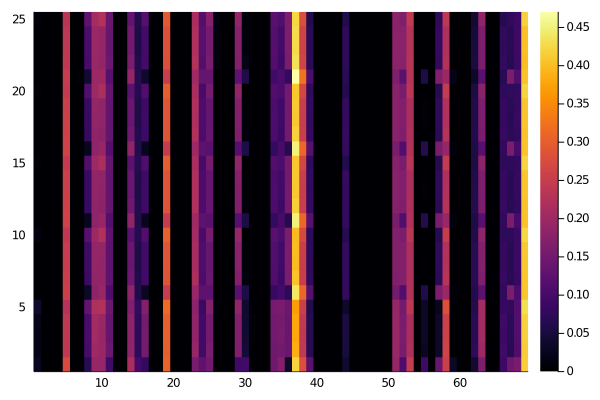

In [62]:
using Plots

heatmap(reshape(a[:, :, :, 1], (25 , 69)))

In [33]:
conv2w

5×5×48×256 Array{Float32,4}:
[:, :, 1, 1] =
 0.000828365  0.0230475  0.0149497  0.0129417    8.73678f-6
 0.0104884    0.0255359  0.0246106  0.0231069    0.00846964
 0.0312482    0.0492174  0.0525671  0.0379431    0.0203253
 0.0196965    0.0400506  0.0335273  0.0214168    0.00231168
 0.00379311   0.0169179  0.0130529  0.00290572  -0.00511638

[:, :, 2, 1] =
  0.00497661  -0.010111    -0.0145138   -0.00670758  -0.0101521
 -0.0024538   -0.0123208   -0.0141726   -0.0139842   -0.0195131
 -0.0117874   -0.0166456   -0.0204072   -0.01848     -0.0166281
 -0.0128672   -0.013946    -0.0128052   -0.0112992   -0.0106853
  0.0106938    0.00183144   0.00738919   0.0105801    0.00454021

[:, :, 3, 1] =
 -0.0102408    -0.00923175  -0.012603     -0.00852568  -0.0148513
 -0.00449217   -0.00327541  -0.00927728   -0.00417971  -0.00989672
 -0.000807469   0.00764966  -0.00250086   -0.00259042  -0.00511627
  0.00451982    0.00681174  -0.00209027   -0.00192395  -0.004497
  0.00480318    0.00467459   0.00072239